Notebook
https://www.learnpytorch.io/02_pytorch_classification/

## 0. Setup

In [308]:
%pip install torch torchvision torchaudio pandas numpy matplotlib tqdm scikit-learn;


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [309]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm

In [310]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [311]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
print(f"Using {device} device")

Using mps device


## 1. Make Data

In this case, we will make a simple dataset of 1000 points. The points form 2 concentric circles. The inner circle contains points with label 1, and the outer circle contains points with label 0. The goal is to train a classifier that can predict the correct label given the x and y coordinates of a point.

In [312]:
# make 1000 samples
n_samples = 1000

# Create circles
X, Y = make_circles(n_samples, noise=0.03, random_state=seed)

# Print some samples
print(f"First 10 samples:\n{X[:10]}")
print(f"First 10 labels:\n{Y[:10]}")

First 10 samples:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First 10 labels:
[1 1 1 1 0 1 1 1 1 0]


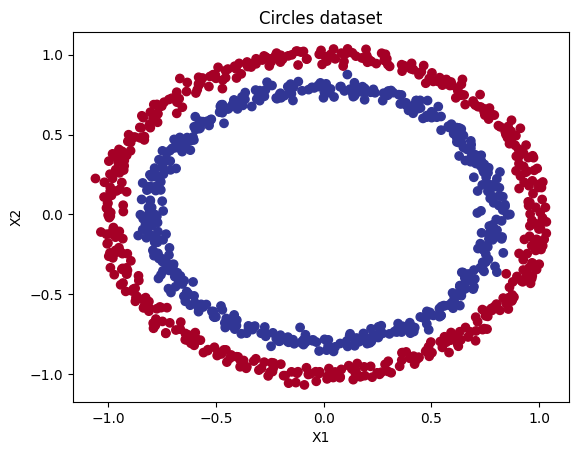

In [313]:
# Turns this into a dataframe
circles_df = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": Y})


def plot_data(X, Y):
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu)

    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Circles dataset")

    plt.show()


plot_data(X, Y)

In [314]:
# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

# Convert to tensors
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Y_train, Y_test = torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()

# Move to device
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

## 2. Building the Model (a bad one)

In [315]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # Alternatively, you can use nn.Sequential
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)

    def forward(self, x):
        x = self.layer_1(x)
        y_logit = self.layer_2(x)

        return y_logit


def get_predictions(y_logits):
    y_pred = torch.round(torch.sigmoid(y_logits))
    return y_pred

In [316]:
model = CircleModelV0().to(device)

parameters = model.state_dict()
for name, param in parameters.items():
    print(f"Parameter {name}, shape: {param.shape}")

Parameter layer_1.weight, shape: torch.Size([5, 2])
Parameter layer_1.bias, shape: torch.Size([5])
Parameter layer_2.weight, shape: torch.Size([1, 5])
Parameter layer_2.bias, shape: torch.Size([1])


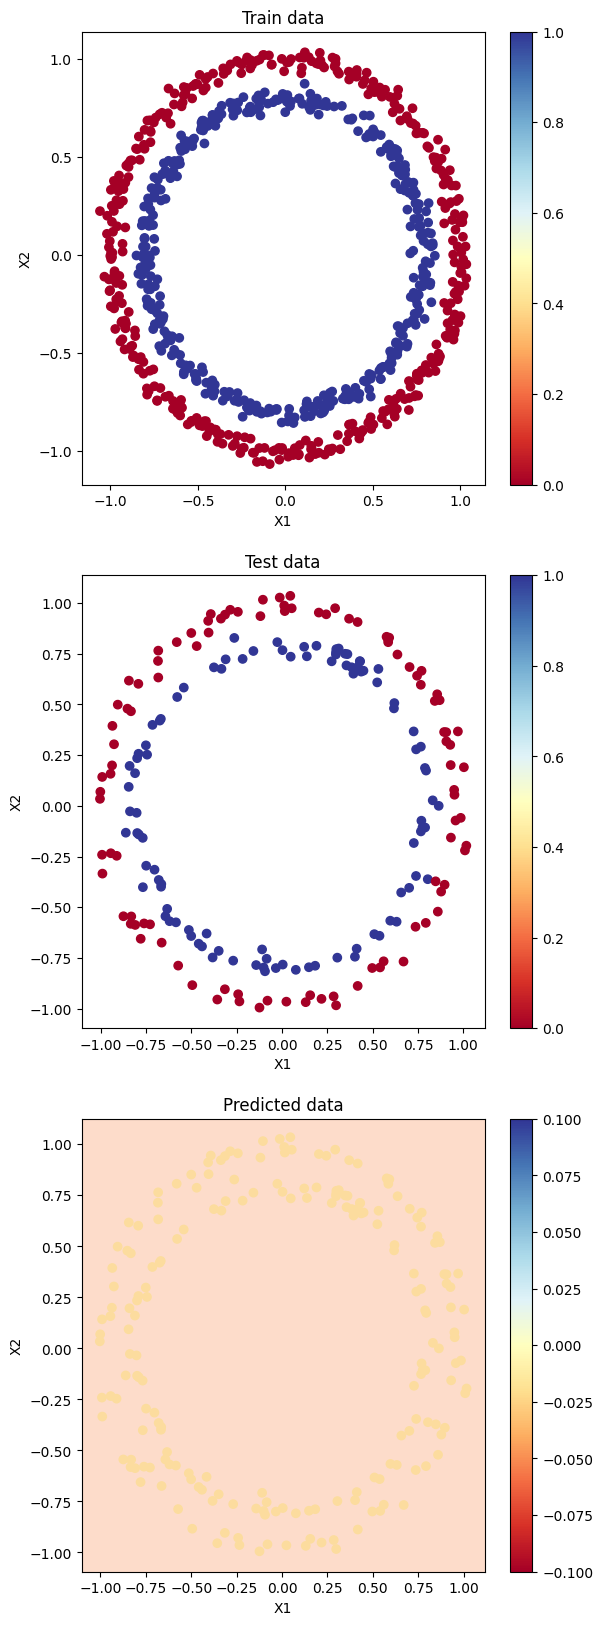

In [317]:
def plot_data(X_train, Y_train, X_test, Y_test, Y_pred=None, model=None):
    # figure with 3 columns
    plt.figure(figsize=(6.5, 20))

    plt.subplot(3, 1, 1)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Train data")
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.RdYlBu)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Test data")
    plt.colorbar()

    if Y_pred is not None:
        plt.subplot(3, 1, 3)
        plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_pred, cmap=plt.cm.RdYlBu)
        plt.xlabel("X1")
        plt.ylabel("X2")
        plt.title("Predicted data")
        plt.colorbar()

        if model is not None:
            # Plot Decision Boundary

            # get min and max for each dimension
            x1_min, x1_max = X_test[:, 0].min() - 0.1, X_test[:, 0].max() + 0.1
            x2_min, x2_max = X_test[:, 1].min() - 0.1, X_test[:, 1].max() + 0.1

            # create grid
            # x1 and x2 have n points each
            # Then xx1 and xx2 represent the matrix of all possible combinations of x1 and x2. So nxn points
            # xx1 and xx2 contain the corresponding x1 and x2 coordinates for each point in the grid
            x1 = np.arange(x1_min, x1_max, 0.01)
            x2 = np.arange(x2_min, x2_max, 0.01)
            xx1, xx2 = np.meshgrid(x1, x2)

            # make predictions for each point in the grid
            # Flatten the grid to get a list of all points with ravel
            # Then concatenate the x1 and x2 coordinates for each point in the grid
            X_grid = np.c_[xx1.ravel(), xx2.ravel()]
            X_grid = torch.from_numpy(X_grid).float().to(device)

            model.eval()
            with torch.inference_mode():
                Y_grid_logits = model(X_grid)
                Y_grid_pred = get_predictions(Y_grid_logits)

                # reshape predictions to the grid shape
                Y_grid_pred = Y_grid_pred.cpu().numpy().reshape(xx1.shape)

            # plot decision boundary
            plt.contourf(xx1, xx2, Y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.3)

    plt.show()


# make some predictions before training
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)

plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

### 3. Training the Model (a bad one)

Our model outs puts are logits, which we can convert into probabilities by passing them through an activation function (eg sigmoid for binary classification or softmax for multiclass classification). 

Then we can convert the probabilities into a predicted class by selecting the class with the highest probability. That is if the output after sigmoid is > 0.5, we predict class 1, otherwise we predict class 0.

In [318]:
def accuracy(Y_pred, Y_true):
    correct = torch.eq(Y_pred, Y_true).sum().item()
    return correct / Y_true.shape[0] * 100

In [319]:
def train(model, X_train, Y_train, X_test, Y_test, epochs):
    loss_fn = nn.BCEWithLogitsLoss()

    lr = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    train_loss, test_loss = [], []
    for epoch in tqdm(range(epochs), desc="Epochs", unit="epoch"):
        model.train()

        Y_train_logits = model(X_train).squeeze()

        # Normal BCE Loss would expect a probability between 0 and 1
        # So if we use BCE Loss, we need to apply sigmoid to the logits
        # Y_train_probs = torch.sigmoid(Y_train_logits)
        # loss = loss_fn(Y_train_probs, Y_train)

        # But we can use BCEWithLogitsLoss which combines sigmoid and BCE Loss
        train_loss = loss_fn(Y_train_logits, Y_train)
        accuracy_train = accuracy(get_predictions(Y_train_logits), Y_train)
        train_losses[epoch] = train_loss.item()

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            Y_test_logits = model(X_test).squeeze()

            test_loss = loss_fn(Y_test_logits, Y_test)
            accuracy_test = accuracy(get_predictions(Y_test_logits), Y_test)
            test_losses[epoch] = test_loss.item()

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch} | Train loss {train_loss:.3f} | Test loss {test_loss:.3f}"
            )
            print(
                f"Epoch {epoch} | Train accuracy {accuracy_train:.2f}% | Test accuracy {accuracy_test:.2f}%"
            )
            print("--------------------------------------------------")

    return train_losses, test_losses


train_losses, test_losses = train(model, X_train, Y_train, X_test, Y_test, epochs=200)

Epochs:  22%|██▏       | 44/200 [00:00<00:00, 220.52epoch/s]

Epoch 0 | Train loss 0.696 | Test loss 0.696
Epoch 0 | Train accuracy 50.00% | Test accuracy 50.00%
--------------------------------------------------


Epochs:  46%|████▋     | 93/200 [00:00<00:00, 234.51epoch/s]

Epoch 50 | Train loss 0.693 | Test loss 0.695
Epoch 50 | Train accuracy 51.00% | Test accuracy 46.00%
--------------------------------------------------


Epochs:  73%|███████▎  | 146/200 [00:00<00:00, 246.83epoch/s]

Epoch 100 | Train loss 0.693 | Test loss 0.695
Epoch 100 | Train accuracy 51.25% | Test accuracy 46.00%
--------------------------------------------------
Epoch 150 | Train loss 0.693 | Test loss 0.695
Epoch 150 | Train accuracy 51.12% | Test accuracy 46.00%
--------------------------------------------------


Epochs: 100%|██████████| 200/200 [00:00<00:00, 242.87epoch/s]


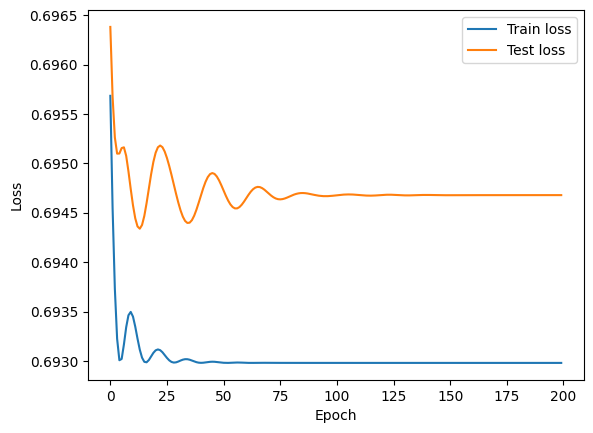

In [320]:
def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()


plot_losses(train_losses, test_losses)

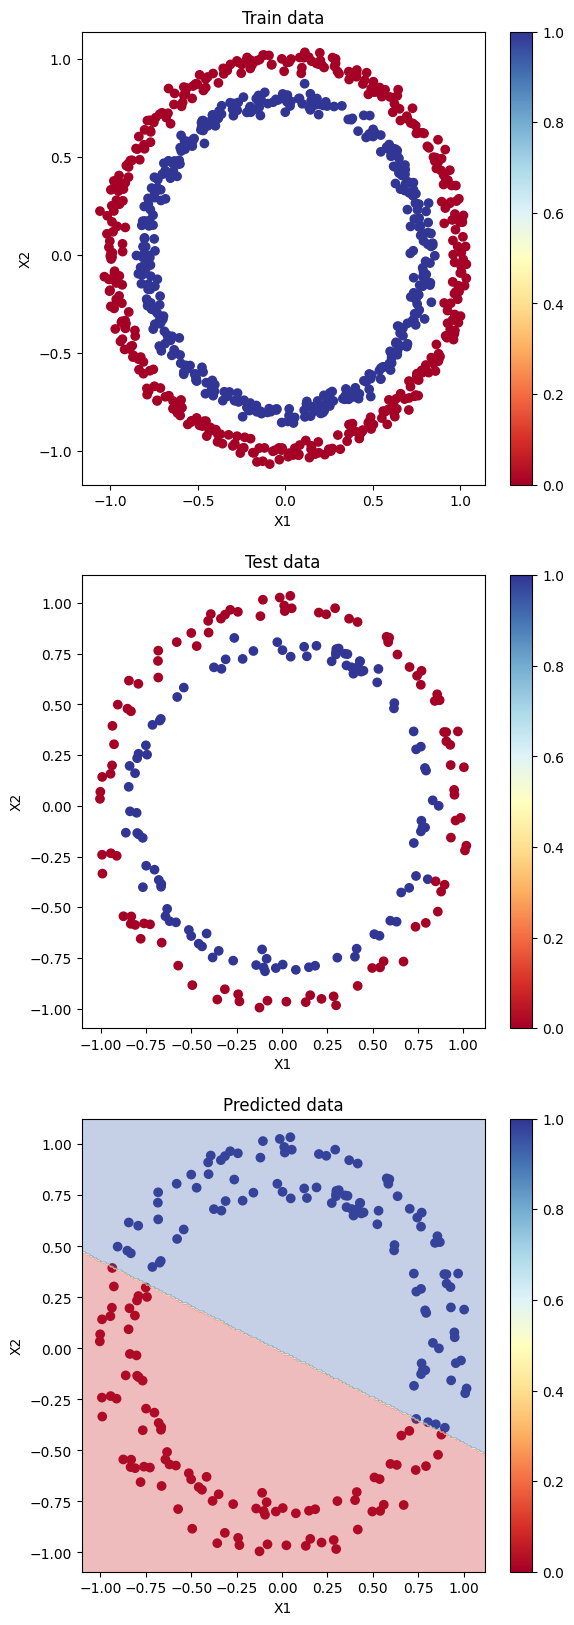

In [321]:
# Visualize the decision boundary
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)

plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

### 4. Building a Better Model

In [322]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )
        

    def forward(self, x):
        return self.layers(x)

In [323]:
model = CircleModelV1().to(device)

parameters = model.state_dict()
for name, param in parameters.items():
    print(f"Parameter {name}, shape: {param.shape}")

Parameter layers.0.weight, shape: torch.Size([8, 2])
Parameter layers.0.bias, shape: torch.Size([8])
Parameter layers.2.weight, shape: torch.Size([8, 8])
Parameter layers.2.bias, shape: torch.Size([8])
Parameter layers.4.weight, shape: torch.Size([1, 8])
Parameter layers.4.bias, shape: torch.Size([1])


### 5. Training the Better Model

Epochs:   2%|▏         | 17/1000 [00:00<00:05, 167.92epoch/s]

Epoch 0 | Train loss 0.702 | Test loss 0.701
Epoch 0 | Train accuracy 50.00% | Test accuracy 50.00%
--------------------------------------------------


Epochs:   8%|▊         | 78/1000 [00:00<00:04, 193.85epoch/s]

Epoch 50 | Train loss 0.654 | Test loss 0.666
Epoch 50 | Train accuracy 56.00% | Test accuracy 52.00%
--------------------------------------------------


Epochs:  14%|█▍        | 138/1000 [00:00<00:04, 196.59epoch/s]

Epoch 100 | Train loss 0.411 | Test loss 0.416
Epoch 100 | Train accuracy 97.12% | Test accuracy 98.00%
--------------------------------------------------


Epochs:  18%|█▊        | 179/1000 [00:00<00:04, 196.38epoch/s]

Epoch 150 | Train loss 0.137 | Test loss 0.158
Epoch 150 | Train accuracy 99.88% | Test accuracy 99.00%
--------------------------------------------------


Epochs:  24%|██▍       | 240/1000 [00:01<00:03, 196.78epoch/s]

Epoch 200 | Train loss 0.072 | Test loss 0.085
Epoch 200 | Train accuracy 100.00% | Test accuracy 99.50%
--------------------------------------------------


Epochs:  28%|██▊       | 280/1000 [00:01<00:03, 180.96epoch/s]

Epoch 250 | Train loss 0.048 | Test loss 0.056
Epoch 250 | Train accuracy 100.00% | Test accuracy 99.50%
--------------------------------------------------


Epochs:  34%|███▍      | 340/1000 [00:01<00:03, 190.42epoch/s]

Epoch 300 | Train loss 0.035 | Test loss 0.042
Epoch 300 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  38%|███▊      | 380/1000 [00:01<00:03, 194.33epoch/s]

Epoch 350 | Train loss 0.027 | Test loss 0.033
Epoch 350 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  42%|████▏     | 419/1000 [00:02<00:03, 184.49epoch/s]

Epoch 400 | Train loss 0.022 | Test loss 0.027
Epoch 400 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  48%|████▊     | 479/1000 [00:02<00:02, 192.99epoch/s]

Epoch 450 | Train loss 0.018 | Test loss 0.023
Epoch 450 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  52%|█████▏    | 519/1000 [00:02<00:02, 192.87epoch/s]

Epoch 500 | Train loss 0.015 | Test loss 0.019
Epoch 500 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  58%|█████▊    | 580/1000 [00:03<00:02, 193.70epoch/s]

Epoch 550 | Train loss 0.013 | Test loss 0.017
Epoch 550 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  62%|██████▏   | 620/1000 [00:03<00:02, 176.80epoch/s]

Epoch 600 | Train loss 0.011 | Test loss 0.015
Epoch 600 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  68%|██████▊   | 678/1000 [00:03<00:01, 182.84epoch/s]

Epoch 650 | Train loss 0.010 | Test loss 0.013
Epoch 650 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  74%|███████▍  | 739/1000 [00:03<00:01, 191.18epoch/s]

Epoch 700 | Train loss 0.009 | Test loss 0.012
Epoch 700 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  78%|███████▊  | 779/1000 [00:04<00:01, 192.71epoch/s]

Epoch 750 | Train loss 0.008 | Test loss 0.011
Epoch 750 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  82%|████████▏ | 819/1000 [00:04<00:00, 189.22epoch/s]

Epoch 800 | Train loss 0.007 | Test loss 0.010
Epoch 800 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  88%|████████▊ | 879/1000 [00:04<00:00, 189.03epoch/s]

Epoch 850 | Train loss 0.006 | Test loss 0.009
Epoch 850 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  94%|█████████▎| 936/1000 [00:04<00:00, 185.88epoch/s]

Epoch 900 | Train loss 0.006 | Test loss 0.009
Epoch 900 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs:  97%|█████████▋| 974/1000 [00:05<00:00, 185.07epoch/s]

Epoch 950 | Train loss 0.005 | Test loss 0.008
Epoch 950 | Train accuracy 100.00% | Test accuracy 100.00%
--------------------------------------------------


Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 188.69epoch/s]


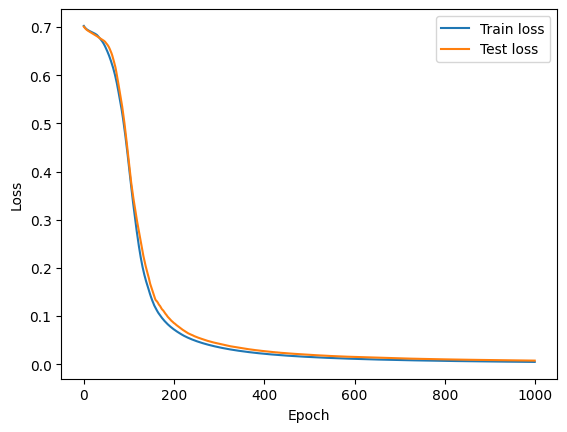

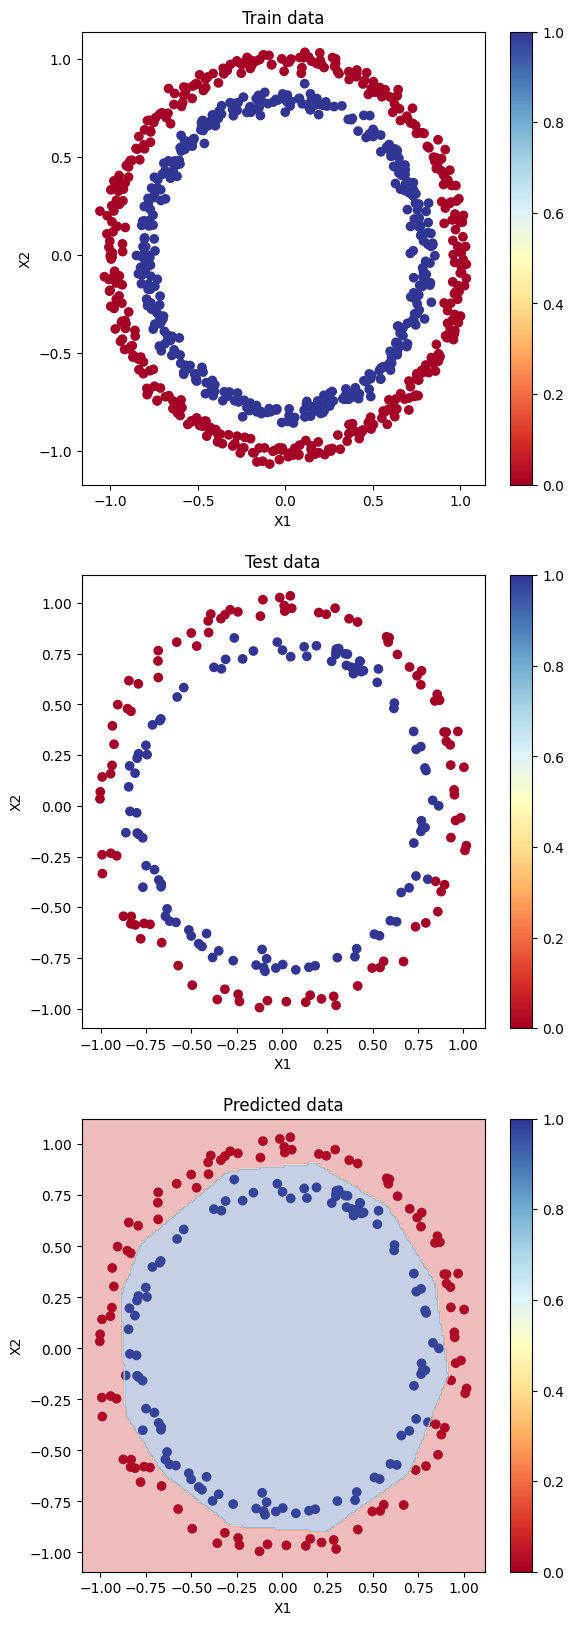

In [324]:
train_losses, test_losses = train(model, X_train, Y_train, X_test, Y_test, epochs=500)

# Visualize the loss
plot_losses(train_losses, test_losses)

# Visualize the decision boundary
model.eval()
with torch.inference_mode():
    Y_logits = model(X_test)
    Y_pred = get_predictions(Y_logits)
plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), model)

## 6. Saving and Loading Models

In [325]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(exist_ok=True)

torch.save(model.state_dict(), model_path / "02_circle_model_v1.pth")

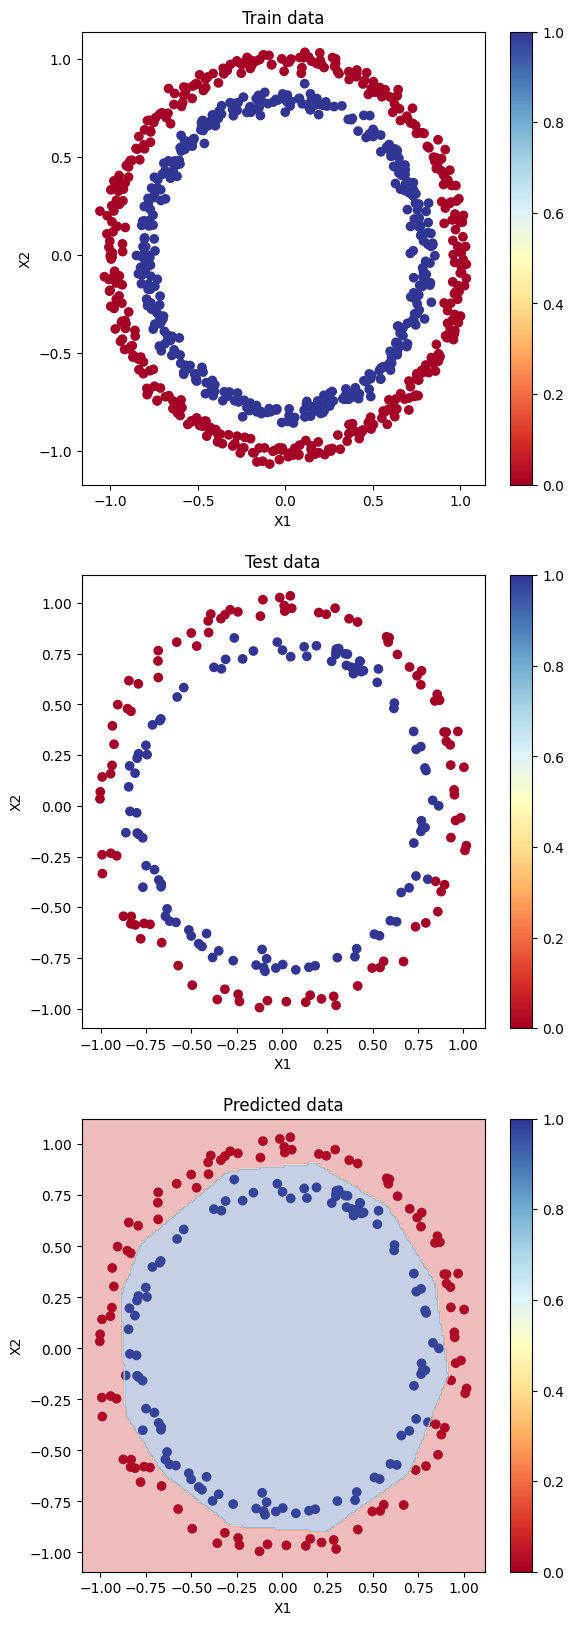

In [326]:
loaded_model = CircleModelV1().to(device)
loaded_model.load_state_dict(torch.load(model_path / "02_circle_model_v1.pth"))

# Visualize the decision boundary
loaded_model.eval()
with torch.inference_mode():
    Y_logits = loaded_model(X_test)
    Y_pred = get_predictions(Y_logits)
plot_data(X_train.cpu(), Y_train.cpu(), X_test.cpu(), Y_test.cpu(), Y_pred.cpu(), loaded_model)